# Finding the best spot for coffee roastery in Kyiv
## (Applied Data Science Capstone, Week 1)
by Oleksandr Holubov

## Table of contents
* [Problem description](#problem)
* [Data description 1](#data_1)
* [Getting clean data 1](#cleaning_1)
* [Reassessing the data](#reassessing)
* [Data description 2](#data_2)
* [Getting clean data 2](#cleaning_2)
* [Data analysis](#analysis)
* [K-Means clustering](#clustering)
* [Results and discussion](#results)

## Problem description <a name="problem"></a>

The **coffee business is expanding in the Ukrainian capital city of Kyiv** in the latest years. Even despite coronavirus pandemic the demand for cafes, coffee shops and coffee points with takeaway coffee is pretty high - there are hundreds of them in the Ukrainian capital.

Hoping that the start of vaccination will boost this market even stronger and a year of pandemic made it a little bit less crowded, Liudmila, a freind of mine and a successfull owner of a cafe in the center of the city, wants to expand her business and kickstart a **new coffee roastery**. She hopes that growing demand and the cafe owners' need to stand out from their competitors will make the fresh, locally roasted coffee beans a highly desired commodity.

Knowing my interest in Data Science Liudmila decided to save some money and do me a favor of getting me my first real project. She asked me to **explore the distribution of coffee venues in Kyiv** and find a **best spot for her future roastery**.

Liudmila's search for the perfect place for the new roastery is determined not only by the real estate or rent prices, but also by the factors like **proximity to the venues that may be potentially interested in bying freshly roasted coffee beans** (cafes, coffee-to-go spots, bars, restaurants) and to the **places of high business and social activity** which means the higher chance to find a wealthy audience that cares about the nuances of coffee taste.

That's why my goal will be to find potentially interesting areas in Kyiv that correspond to the following demands:

* Location in the area **with lots of cafes, coffee points and other venues** of potential interest,
* Location in the area **with high business and/or social activity** (shopping malls, business centres, stores, art galleries, boutiques etc.

It's important that the outcome **does not need to be a single spot**. Liudmila is more interested in a comparison of different areas, because other considerations may come into play later. It means we should look for a **cluster of spots** that fit our demands the best way.

## Data description 1 <a name="data_1"></a>

Our first guess with Liudmila was to analyze, compare, and cluster **10 Kyiv districts** that have very different population, infrastracture and venues available for their residents. Based on definition of our problem, we will try to find the districts that match our demands that were mentioned above the best way.

For our analysis we will be using following data:
* **List of districts** from the table in the Wikipedia article ["Urban districts of Ukraine"](https://en.wikipedia.org/wiki/Urban_districts_of_Ukraine#Kyiv),
* geopy Python client to convert the names of districts into **latitude and longitude values**,
* **Forsquare location data** using Forsquare API.

## Getting clean data 1 <a name="cleaning_1"></a>

First, let's **import pandas** to scrape a table with **Kyiv district names** from Wikipedia and get it **as a dataframe**.

In [479]:
import pandas as pd

In [480]:
link = "https://en.wikipedia.org/wiki/Urban_districts_of_Ukraine"
k_dist = pd.read_html(link,header=0)[2]

k_dist

,#,Name in English,Name in Ukrainian(Ukrainian Wikipedia),Area(km²),"Population December 1, 2001",Density(people on 1 km²)
0,1,Holosiivskyi,Голосіївський,156,202993,1301
1,2,Darnytskyi,Дарницький,134,282359,2107
2,3,Desnianskyi,Деснянський,148,336209,2272
3,4,Dniprovskyi,Дніпровський,67,331618,4950
4,5,Obolonskyi,Оболонський,110,306173,2783
5,6,Pecherskyi,Печерський,20,131127,6556
6,7,Podilskyi,Подільський,34,180424,5307
7,8,Sviatoshynskyi,Святошинський,103,315410,3062
8,9,Solomianskyi,Солом'янський,40,287801,7195
9,10,Shevchenkivskyi,Шевченківський,27,237213,8786


Now let's **import Nominatim** and write a loop to **convert the names of districts into latitude and longitude values**.

In [ ]:
from geopy.geocoders import Nominatim

In [481]:
# Let's copy a dataframe and create lists for latitude and longitude values

k_dist_loc = k_dist
latitudes = []
longitudes = []

# Making a loop with a user agent "kyiv_explorer"

for district in k_dist_loc['Name in English']:
    address = '{} district, Kyiv'.format(district)
    geolocator = Nominatim(user_agent="kyiv_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    latitudes.append(latitude)
    longitude = location.longitude
    longitudes.append(longitude)
    
# Let's create columns with latitude and longitude values in our new dataframe
    
k_dist_loc['Latitude'] = latitudes
k_dist_loc['Longitude'] = longitudes

# Let's rename a column 'Name in English' into a more convenient 'District'

k_dist_loc.rename(columns={'Name in English': 'District'}, inplace=True)

# Now it's high time to get rid from columns we're not going to use

k_dist_loc = k_dist_loc.filter(['District', 'Latitude', 'Longitude'], axis=1)

k_dist_loc

,District,Latitude,Longitude
0,Holosiivskyi,50.327315,30.555651
1,Darnytskyi,50.403607,30.710942
2,Desnianskyi,50.519069,30.661321
3,Dniprovskyi,50.456361,30.583740
4,Obolonskyi,50.531853,30.432124
5,Pecherskyi,50.428719,30.548939
6,Podilskyi,50.489557,30.428504
7,Sviatoshynskyi,50.472703,30.324879
8,Solomianskyi,50.420548,30.458485
9,Shevchenkivskyi,50.462644,30.451652


Now let's get the geographical **coordinates of Kyiv**.

In [482]:
kyiv_address = 'Kyiv'

kyiv_geolocator = Nominatim(user_agent="kyiv_explorer")
kyiv_location = geolocator.geocode(kyiv_address)
kyiv_latitude = kyiv_location.latitude
kyiv_longitude = kyiv_location.longitude
print('The geograpical coordinates of Kyiv are {}, {}.'.format(kyiv_latitude, kyiv_longitude))

The geograpical coordinates of Kyiv are 50.4500336, 30.5241361.


Next step will be importing folium to make a **map of Kyiv with its districts**.

In [483]:
import folium

In [485]:
map_kyiv = folium.Map(location=[kyiv_latitude, kyiv_longitude], zoom_start=11)

for lat, lng, district in zip(k_dist_loc['Latitude'], k_dist_loc['Longitude'], k_dist_loc['District']):
    label = '{}'.format(district)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_kyiv)  
    
map_kyiv

## Reassessing the data <a name="reassessing"></a>

Finding some district centers right in the forest made me stop my analysis and contact Liudmila. It was obvious that we should reassess our approach. The vast areas of some districts made their geospatial data uncompatible with our goal.

## Data description 2 <a name="data_2"></a>

I decided to propose Liudmila to use another location "anchor" for our analysis.

**Kyiv metro** (undeground city railway) is of the great importance for the city. Its three lines cross Kyiv in three directions covering **all the districts** and the vast majority of neighbourhoods. Its stations are **mostly evenly distributed** at an approximate 1,3 kilometer distance one from another.

Moreover, because of the dire state of other means of public transport, metro is crucial not only from the infrastractural point of view. Proximity to the metro **directly influences the real estate prices** and makes them **hubs of economical and social activity** in the city. Which directly **corresponds to the goals of our analysis**.

Liudmila found this approach even better because of logistical reasons. Her couriers will be able to deliver small packages of coffee beans without necessity to use extremly busy Kyiv streets (another reason that makes metro so crucial for the city).

So we decided to look at, compare, and cluster **52 Kyiv metro stations**. Based on definition of our problem, we will try to find stations that match our mentioned above demands the best way.

For our analysis we will be using following data:

* **List of metro stations** scraped from the Wikipedia article ["List of Kyiv Metro stations"](https://en.wikipedia.org/wiki/List_of_Kyiv_Metro_stations),
* geopy Python client to convert the names of districts into **latitude and longitude values**,
* **Forsquare location** data using Forsquare API.

## Getting clean data 2 <a name="cleaning_2"></a>

Let's import URL handling module urlib and BeautifulSoup to **scrape the Wikipedia page**.

In [103]:
import urllib.request
from bs4 import BeautifulSoup

In [487]:
# defining the url of the page we're trying to scrape and opening it

url = 'https://en.wikipedia.org/wiki/List_of_Kyiv_Metro_stations'
page = urllib.request.urlopen(url)
soup = BeautifulSoup(page, "lxml")

Let's have a look at the **page code** using BeautifulSoup

In [488]:
print(soup.prettify())

<!DOCTYPE html>
<html class="client-nojs" dir="ltr" lang="en">
 <head>
  <meta charset="utf-8"/>
  <title>
   List of Kyiv Metro stations - Wikipedia
  </title>
  <script>
   document.documentElement.className="client-js";RLCONF={"wgBreakFrames":!1,"wgSeparatorTransformTable":["",""],"wgDigitTransformTable":["",""],"wgDefaultDateFormat":"dmy","wgMonthNames":["","January","February","March","April","May","June","July","August","September","October","November","December"],"wgRequestId":"33f29247-b7ad-4ba6-83de-1108f86e18d6","wgCSPNonce":!1,"wgCanonicalNamespace":"","wgCanonicalSpecialPageName":!1,"wgNamespaceNumber":0,"wgPageName":"List_of_Kyiv_Metro_stations","wgTitle":"List of Kyiv Metro stations","wgCurRevisionId":984730332,"wgRevisionId":984730332,"wgArticleId":9171454,"wgIsArticle":!0,"wgIsRedirect":!1,"wgAction":"view","wgUserName":null,"wgUserGroups":["*"],"wgCategories":["Articles with short description","Short description is different from Wikidata","Commons category link is on 

It looks like 'ol' tag is what we're looking for. Let's read the text under the first such tag to get the names of the stations from the **first metro line**.

In [489]:
line1_stations = soup.find_all('ol')[0].text
line1_stations

'Akademmistechko\nZhytomyrska\nSviatoshyn\nNyvky\nBeresteiska\nShuliavska\nPolitekhnichnyi Instytut\nVokzalna\nUniversytet\nTeatralna → Zoloti Vorota \nKhreshchatyk → Maidan Nezalezhnosti \nArsenalna\nDnipro\nHidropark\nLivoberezhna\nDarnytsia\nChernihivska\nLisova'

Perfect. We've got a string with the names of the stations belonging to the **first line** of Kyiv metro. Now let's make a list out of this string using '\n' separator.

In [490]:
line1_stations = line1_stations.split('\n')
line1_stations

['Akademmistechko',
 'Zhytomyrska',
 'Sviatoshyn',
 'Nyvky',
 'Beresteiska',
 'Shuliavska',
 'Politekhnichnyi Instytut',
 'Vokzalna',
 'Universytet',
 'Teatralna → Zoloti Vorota ',
 'Khreshchatyk → Maidan Nezalezhnosti ',
 'Arsenalna',
 'Dnipro',
 'Hidropark',
 'Livoberezhna',
 'Darnytsia',
 'Chernihivska',
 'Lisova']

Now let's get the list of **second** line stations names.

In [491]:
line2_stations = soup.find_all('ol')[1].text
line2_stations = line2_stations.split('\n')
line2_stations

['Heroiv Dnipra',
 'Minska',
 'Obolon',
 'Pochaina',
 'Tarasa Shevchenka',
 'Kontraktova Ploshcha',
 'Poshtova Ploshcha',
 'Maidan Nezalezhnosti → Khreshchatyk ',
 'Ploshcha Lva Tolstoho → Palats Sportu ',
 'Olimpiiska',
 'Palats "Ukrayina"',
 'Lybidska',
 'Demiivska',
 'Holosiivska',
 'Vasylkivska',
 'Vystavkovyi Tsentr',
 'Ipodrom',
 'Teremky']

And **third**.

In [492]:
line3_stations = soup.find_all('ol')[2].text
line3_stations = line3_stations.split('\n')
line3_stations

['Syrets',
 'Dorohozhychi',
 'Lukianivska',
 'Lvivska Brama ',
 'Zoloti Vorota → Teatralna ',
 'Palats Sportu → Ploshcha Lva Tolstoho ',
 'Klovska',
 'Pecherska',
 'Druzhby Narodiv',
 'Vydubychi',
 'Telychka ',
 'Slavutych',
 'Osokorky',
 'Pozniaky',
 'Kharkivska',
 'Vyrlytsia',
 'Boryspilska',
 'Chervony Khutir']

Now let's **merge all three lists** into a single one.

In [493]:
all_stations = line1_stations + line2_stations + line3_stations
all_stations

['Akademmistechko',
 'Zhytomyrska',
 'Sviatoshyn',
 'Nyvky',
 'Beresteiska',
 'Shuliavska',
 'Politekhnichnyi Instytut',
 'Vokzalna',
 'Universytet',
 'Teatralna → Zoloti Vorota ',
 'Khreshchatyk → Maidan Nezalezhnosti ',
 'Arsenalna',
 'Dnipro',
 'Hidropark',
 'Livoberezhna',
 'Darnytsia',
 'Chernihivska',
 'Lisova',
 'Heroiv Dnipra',
 'Minska',
 'Obolon',
 'Pochaina',
 'Tarasa Shevchenka',
 'Kontraktova Ploshcha',
 'Poshtova Ploshcha',
 'Maidan Nezalezhnosti → Khreshchatyk ',
 'Ploshcha Lva Tolstoho → Palats Sportu ',
 'Olimpiiska',
 'Palats "Ukrayina"',
 'Lybidska',
 'Demiivska',
 'Holosiivska',
 'Vasylkivska',
 'Vystavkovyi Tsentr',
 'Ipodrom',
 'Teremky',
 'Syrets',
 'Dorohozhychi',
 'Lukianivska',
 'Lvivska Brama ',
 'Zoloti Vorota → Teatralna ',
 'Palats Sportu → Ploshcha Lva Tolstoho ',
 'Klovska',
 'Pecherska',
 'Druzhby Narodiv',
 'Vydubychi',
 'Telychka ',
 'Slavutych',
 'Osokorky',
 'Pozniaky',
 'Kharkivska',
 'Vyrlytsia',
 'Boryspilska',
 'Chervony Khutir']

Now let's make our list **clean** and ready for the next step:

* Let's get rid of the **arrows and names of stations passengers're able to transfer to**. We will be using a loop for this task.
* Let's **rename two stations**. Further analysis will show that scraped names does not correspond the names that geopy uses for this stations. Therefore it will get the wrong coordinates. To spare you from doing all the wrong steps finding the bug and getting here back to fix it, let's just change the names manually to process further.
* Let's get rid of the **names of stations that are still in construction** and therefore closed.

In [494]:
for n, station in enumerate(all_stations):
    if station.find(" →") != -1:
        head, sep, tail = station.partition(' →')
        all_stations[n] = head

all_stations[13] = 'Hydropark'
all_stations[-1] = 'Chervonyi Khutir'
all_stations.remove('Lvivska Brama ')
all_stations.remove('Telychka ')

# Let's have a look at the final list

all_stations

['Akademmistechko',
 'Zhytomyrska',
 'Sviatoshyn',
 'Nyvky',
 'Beresteiska',
 'Shuliavska',
 'Politekhnichnyi Instytut',
 'Vokzalna',
 'Universytet',
 'Teatralna',
 'Khreshchatyk',
 'Arsenalna',
 'Dnipro',
 'Hydropark',
 'Livoberezhna',
 'Darnytsia',
 'Chernihivska',
 'Lisova',
 'Heroiv Dnipra',
 'Minska',
 'Obolon',
 'Pochaina',
 'Tarasa Shevchenka',
 'Kontraktova Ploshcha',
 'Poshtova Ploshcha',
 'Maidan Nezalezhnosti',
 'Ploshcha Lva Tolstoho',
 'Olimpiiska',
 'Palats "Ukrayina"',
 'Lybidska',
 'Demiivska',
 'Holosiivska',
 'Vasylkivska',
 'Vystavkovyi Tsentr',
 'Ipodrom',
 'Teremky',
 'Syrets',
 'Dorohozhychi',
 'Lukianivska',
 'Zoloti Vorota',
 'Palats Sportu',
 'Klovska',
 'Pecherska',
 'Druzhby Narodiv',
 'Vydubychi',
 'Slavutych',
 'Osokorky',
 'Pozniaky',
 'Kharkivska',
 'Vyrlytsia',
 'Boryspilska',
 'Chervonyi Khutir']

Let's create an **empty dataframe** for our stations and their coordinates.

In [495]:
column_names = ['Station', 'Latitude', 'Longitude'] 
stations = pd.DataFrame(columns=column_names)
stations

,Station,Latitude,Longitude


Now let's write a loop to convert the **names of districts into latitude and longitude values** and add all three of them to our empty dataframe.

In [496]:
latitudes = []
longitudes = []

for station in all_stations:
    address = '{} metro station, Kyiv'.format(station)
    geolocator = Nominatim(user_agent="metro_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    latitudes.append(latitude)
    longitude = location.longitude
    longitudes.append(longitude)
    
# Let's add all the data to our empty dataframe now
    
stations['Station'] = all_stations
stations['Latitude'] = latitudes
stations['Longitude'] = longitudes

# And now let's have a look at it

stations

,Station,Latitude,Longitude
0,Akademmistechko,50.464704,30.355083
1,Zhytomyrska,50.456172,30.365873
2,Sviatoshyn,50.457583,30.392986
3,Nyvky,50.458596,30.404205
4,Beresteiska,50.459092,30.419688
5,Shuliavska,50.455075,30.445370
6,Politekhnichnyi Instytut,50.450793,30.466127
7,Vokzalna,50.441640,30.488251
8,Universytet,50.444247,30.505893
9,Teatralna,50.445175,30.517990


Now let's make a **map of Kyiv** with **all the stations**.

In [498]:
map_kyiv = folium.Map(location=[kyiv_latitude, kyiv_longitude], zoom_start=11)

for lat, lng, station in zip(stations['Latitude'], stations['Longitude'], stations['Station']):
    label = '{}'.format(station)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_kyiv)  
    
map_kyiv

Now that we have station locations and they look right, let's use Foursquare API to **get info on venues around** them.

Foursquare **credentials and version** are defined in hidden cell bellow. We will retrieve data from 26.03.2021.

In [584]:
# The code was removed by Watson Studio for sharing.

Let's start exploring the **first station** in the dataframe and get its name first.

In [585]:
stations.loc[0, 'Station']

'Akademmistechko'

Now let's get its **latitude and longitude** values.

In [586]:
station_latitude = stations.loc[0, 'Latitude']
station_longitude = stations.loc[0, 'Longitude']

station_name = stations.loc[0, 'Station']

print('Latitude and longitude values of {} are {}, {}.'.format(station_name, 
                                                               station_latitude, 
                                                              station_longitude))

Latitude and longitude values of Akademmistechko are 50.4647043, 30.3550833.


Defining **an url** for the request to **find top 100 venues** near the first station.

Let's set the **radius to 700** because the average distance between stations is 1,3 km.

In [587]:
radius = 700

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    station_latitude, 
    station_longitude, 
    radius, 
    LIMIT)

Let's import libraries to **send requests** and **handle JSON files**.

In [588]:
import requests
import json

Sending **GET** reguest and saving data

In [589]:
results = requests.get(url).json()

Let's create a function that **extracts the category** of the venue.

In [590]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Now let's **clean the json** and structure it into a pandas **dataframe**.

In [591]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = pd.json_normalize(venues)

filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues = nearby_venues.loc[:, filtered_columns]

nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Erotic Shop (Академгородок),Adult Boutique,50.463795,30.354959
1,Roshen,Candy Store,50.464142,30.355395
2,Бутик No Taboo (Академгородок),Adult Boutique,50.465423,30.355489
3,Bella Grano,Coffee Shop,50.465448,30.354435
4,Море Пива,Beer Store,50.463850,30.355314


Let's find out the **number of venues** returned

In [592]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

40 venues were returned by Foursquare.


Everything worked well. Now let's create a function to **repeat the same process to all the stations** in Kyiv.

In [593]:
def getNearbyVenues(names, latitudes, longitudes, radius=700):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Station', 
                  'Station Latitude', 
                  'Station Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Now let's create a **new dataframe** called metro_venues.

In [594]:
metro_venues = getNearbyVenues(names=stations['Station'],
                               latitudes=stations['Latitude'],
                               longitudes=stations['Longitude']
                              )

print(metro_venues.shape)
metro_venues.head()

Akademmistechko
Zhytomyrska
Sviatoshyn
Nyvky
Beresteiska
Shuliavska
Politekhnichnyi Instytut
Vokzalna
Universytet
Teatralna
Khreshchatyk
Arsenalna
Dnipro
Hydropark
Livoberezhna
Darnytsia
Chernihivska
Lisova
Heroiv Dnipra
Minska
Obolon
Pochaina
Tarasa Shevchenka
Kontraktova Ploshcha
Poshtova Ploshcha
Maidan Nezalezhnosti
Ploshcha Lva Tolstoho
Olimpiiska
Palats "Ukrayina"
Lybidska
Demiivska
Holosiivska
Vasylkivska
Vystavkovyi Tsentr
Ipodrom
Teremky
Syrets
Dorohozhychi
Lukianivska
Zoloti Vorota
Palats Sportu
Klovska
Pecherska
Druzhby Narodiv
Vydubychi
Slavutych
Osokorky
Pozniaky
Kharkivska
Vyrlytsia
Boryspilska
Chervonyi Khutir
(2989, 7)


,Station,Station Latitude,Station Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Akademmistechko,50.464704,30.355083,Erotic Shop (Академгородок),50.463795,30.354959,Adult Boutique
1,Akademmistechko,50.464704,30.355083,Roshen,50.464142,30.355395,Candy Store
2,Akademmistechko,50.464704,30.355083,Бутик No Taboo (Академгородок),50.465423,30.355489,Adult Boutique
3,Akademmistechko,50.464704,30.355083,Bella Grano,50.465448,30.354435,Coffee Shop
4,Akademmistechko,50.464704,30.355083,Море Пива,50.463850,30.355314,Beer Store


## Data analysis <a name="analysis"></a>

After getting the dataframe with the venues around all the Kyiv metro stations let's have a look at this data trying to get the first insights.

First, let's check **how many venues** were returned for each station.

In [595]:
metro_venues.groupby('Station').count()

,Station Latitude,Station Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Station,,,,,,
Akademmistechko,40,40,40,40,40,40
Arsenalna,71,71,71,71,71,71
Beresteiska,34,34,34,34,34,34
Boryspilska,12,12,12,12,12,12
Chernihivska,51,51,51,51,51,51
Chervonyi Khutir,5,5,5,5,5,5
Darnytsia,46,46,46,46,46,46
Demiivska,54,54,54,54,54,54
Dnipro,23,23,23,23,23,23


So, the first hint is there. 9 stations, namely **Khreshchatyk, Kontraktova Ploshcha, Maidan Nezalezhnosti, Olimpiiska, Palats Sportu, Ploshcha Lva Tolstoho, Pozniaky, Teatralna, Zoloti Vorota**, all do have **at least 100 venues around**. It's legitimate to expect - they are **hubs of high economic and social activity** in the city.

Let's find out how many **unique categories** can be curated from all the returned venues.

In [596]:
print('There are {} uniques categories.'.format(len(metro_venues['Venue Category'].unique())))

There are 328 uniques categories.


But, first of all, we are particularly **interested in the coffee places**. Let's try to find out which venues are the most popular among all of these spots.

Let's start wit **one-hot encoding** the dataframe.

In [597]:
metro_onehot = pd.get_dummies(metro_venues[['Venue Category']], prefix="", prefix_sep="")

metro_onehot['Station'] = metro_venues['Station'] 

fixed_columns = [metro_onehot.columns[-1]] + list(metro_onehot.columns[:-1])
metro_onehot = metro_onehot[fixed_columns]

metro_onehot.head()

,Station,Adult Boutique,American Restaurant,Amphitheater,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,...,Warehouse Store,Waterfront,West-Ukrainian Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Akademmistechko,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Akademmistechko,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Akademmistechko,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Akademmistechko,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Akademmistechko,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now let's find out the **size of the new dataframe**.

In [598]:
metro_onehot.shape

(2989, 329)

Let's **group rows by station** and by taking the **mean of the frequency of occurrence of each category**.

In [634]:
metro_grouped = metro_onehot.groupby('Station').mean().reset_index()
metro_grouped.head()

,Station,Adult Boutique,American Restaurant,Amphitheater,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,...,Warehouse Store,Waterfront,West-Ukrainian Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Akademmistechko,0.05,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
1,Arsenalna,0.00,0.0,0.014085,0.0,0.014085,0.0,0.0,0.0,0.0,...,0.014085,0.0,0.000000,0.0,0.014085,0.0,0.0,0.014085,0.0,0.0
2,Beresteiska,0.00,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
3,Boryspilska,0.00,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
4,Chernihivska,0.00,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.019608,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0


And now the **size** is...

In [600]:
metro_grouped.shape

(52, 329)

Let's find out the **most frequent venues** for each station.

In [635]:
num_top_venues = 5

for station in metro_grouped['Station']:
    print("----"+station+"----")
    temp = metro_grouped[metro_grouped['Station'] == station].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Akademmistechko----
            venue  freq
0     Coffee Shop  0.15
1     Pizza Place  0.10
2             Gym  0.08
3  Adult Boutique  0.05
4          Bakery  0.05


----Arsenalna----
                  venue  freq
0           Coffee Shop  0.11
1                  Café  0.04
2                 Hotel  0.03
3  Caucasian Restaurant  0.03
4     Outdoor Sculpture  0.03


----Beresteiska----
          venue  freq
0   Coffee Shop  0.12
1          Lake  0.09
2          Park  0.06
3     BBQ Joint  0.06
4  Dance Studio  0.06


----Boryspilska----
            venue  freq
0            Café  0.25
1     Coffee Shop  0.17
2          Forest  0.08
3       Rest Area  0.08
4  Discount Store  0.08


----Chernihivska----
                 venue  freq
0          Coffee Shop  0.12
1       Clothing Store  0.12
2                 Park  0.06
3  Sporting Goods Shop  0.04
4       Cosmetics Shop  0.04


----Chervonyi Khutir----
                   venue  freq
0            Outdoor Gym   0.4
1          Metro Station  

And now let's **import numpy** to write a loop that will put previous results **into a pandas dataframe**.

In [602]:
import numpy as np

In [692]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

columns = ['Station']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

metro_venues_sorted = pd.DataFrame(columns=columns)
metro_venues_sorted['Station'] = metro_grouped['Station']

for ind in np.arange(metro_grouped.shape[0]):
    metro_venues_sorted.iloc[ind, 1:] = return_most_common_venues(metro_grouped.iloc[ind, :], num_top_venues)

metro_venues_sorted

,Station,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Akademmistechko,Coffee Shop,Pizza Place,Gym,Soccer Field,Shopping Mall,Supermarket,Bakery,Restaurant,Adult Boutique,Bus Stop
1,Arsenalna,Coffee Shop,Café,Outdoor Sculpture,Park,Bakery,Plaza,Caucasian Restaurant,Asian Restaurant,Hotel,Brewery
2,Beresteiska,Coffee Shop,Lake,Dance Studio,BBQ Joint,Park,Pharmacy,Health & Beauty Service,Photography Lab,Gym / Fitness Center,Gym
3,Boryspilska,Café,Coffee Shop,Rest Area,Ukrainian Restaurant,Discount Store,Cafeteria,Forest,Tram Station,Breakfast Spot,Indian Chinese Restaurant
4,Chernihivska,Coffee Shop,Clothing Store,Park,Pizza Place,Sporting Goods Shop,Cosmetics Shop,Fried Chicken Joint,Gym / Fitness Center,Multiplex,Tennis Court
5,Chervonyi Khutir,Outdoor Gym,Metro Station,Bus Stop,Forest,Flower Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Film Studio,Fish Market
6,Darnytsia,Coffee Shop,Candy Store,Bakery,Ukrainian Restaurant,Clothing Store,Hotel,Fabric Shop,Arts & Crafts Store,Rock Climbing Spot,Liquor Store
7,Demiivska,Coffee Shop,Gym,Pharmacy,Gym / Fitness Center,Dance Studio,Café,Salon / Barbershop,Clothing Store,Sushi Restaurant,Flower Shop
8,Dnipro,Boat or Ferry,Coffee Shop,History Museum,Waterfront,Bus Stop,Student Center,Church,Park,Historic Site,Ukrainian Restaurant
9,Dorohozhychi,Coffee Shop,Cosmetics Shop,Park,Beer Store,Gym / Fitness Center,Athletics & Sports,Electronics Store,Monument / Landmark,Clothing Store,Toy / Game Store


As we can see, coffee venues in one or other form are among the most popular spots near almost every station in Kyiv. It's good news illustrating that our business idea will be met by a thriving market. But, having such picture, it is difficult to choose between spots.

And it's all about a relative popularity for a given station. But how many coffee spots does it actually mean? We need to **take a look at absolute numbers**.

So let's count coffee spots quantity near every metro station in Kyiv. We will be looking for three most popular coffee venue categories in our analysis: **coffee shops, cafes and cafeterias**. Let's create a **new dataframe** in which only these venue categories are left.

In [604]:
coffee_places = metro_venues[metro_venues['Venue Category'].isin(['Coffee Shop','Café','Cafeteria'])] 

coffee_places.head()

,Station,Station Latitude,Station Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
3,Akademmistechko,50.464704,30.355083,Bella Grano,50.465448,30.354435,Coffee Shop
6,Akademmistechko,50.464704,30.355083,Арома,50.463461,30.354888,Coffee Shop
18,Akademmistechko,50.464704,30.355083,КофеЛайк,50.464686,30.356639,Coffee Shop
24,Akademmistechko,50.464704,30.355083,Blasercafe,50.464710,30.354269,Coffee Shop
30,Akademmistechko,50.464704,30.355083,"Coffee club ""Family""",50.460711,30.347927,Coffee Shop


Now we can check **how many coffee venues** were returned for each station.

In [605]:
coffee_places.groupby('Station').count()

,Station Latitude,Station Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Station,,,,,,
Akademmistechko,7,7,7,7,7,7
Arsenalna,11,11,11,11,11,11
Beresteiska,4,4,4,4,4,4
Boryspilska,6,6,6,6,6,6
Chernihivska,7,7,7,7,7,7
Darnytsia,6,6,6,6,6,6
Demiivska,7,7,7,7,7,7
Dnipro,2,2,2,2,2,2
Dorohozhychi,4,4,4,4,4,4


As we can see these 16 stations have 10 or more coffee spots near them: **Arsenalna, Khreshchatyk, Kontraktova Ploshcha, Lisova, Lukianivska, Maidan Nezalezhnosti, Obolon, Palats Sportu, Ploshcha Lva Tolstoho, Poshtova Ploshcha, Pozniaky, Shuliavska, Tarasa Shevchenka, Teatralna, Vasylkivska, Zoloti Vorota**.

8 of them, namely **Khreshchatyk, Kontraktova Ploshcha, Maidan Nezalezhnosti, Palats Sportu, Ploshcha Lva Tolstoho, Pozniaky, Teatralna, Zoloti Vorota**, were among the stations with more than 100 venues around them. This makes them the perfect candidates for the new roastery by now.

It looks like we've sold the first task and have a list of **metro stations with the largest numbers of coffee venues in the areas around them** and are near to solve the second task finding **ones with the attributes of high business and/or social activity**.

To be sure that all other venues are actually attributes of thriving economical and social life around given stations we can use the dataframe with the most popular venues near the metro stations. But instead of comparing them manually let's try to cluster the stations to **find clusters that could match our demands**.

## K-Means clustering <a name="clustering"></a>

First, let's find out the **optimal value of K** for our algorithm.

We will plot the various values of cost with changing K. As the value of K increases, there will be fewer elements in the cluster. So average distortion will decrease. The lesser number of elements means closer to the centroid. So, the point where this distortion declines the most will be our **elbow point** with an optimal value of K.

We'll need **KMeans** and **pyplot** as our tools for this task, so let's import them.

In [706]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

Now let's use an **elbow method** to find the point where distortion declines the most.

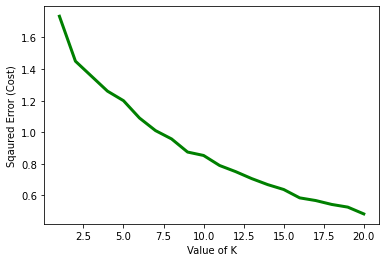

In [709]:
# let's have a separate dataframe for this task
metro_grouped_elbow = metro_grouped.drop('Station', 1)

cost =[]
for i in range(1, 21):
    KM = KMeans(n_clusters = i, max_iter = 500)
    KM.fit(metro_grouped_elbow)
    # calculates squared error for the clustered points
    cost.append(KM.inertia_)     

# now let's plot the cost against K values
plt.plot(range(1, 21), cost, color ='g', linewidth ='3')
plt.xlabel("Value of K")
plt.ylabel("Sqaured Error (Cost)")
plt.show()

It looks like we **do not have a clear elbow point** here. Nevertheless, the points where distortion declines the most seem to be the **values of K of 2 and 9**.

Rather arbitrary I think to **start from the 9 clusters** will be more poductive for our analysis. We don't want our clusters to be neither too broad, nor too specific.

So **let's run K-Means** to cluster our stations into 9 clusters.

In [693]:
kclusters = 9

metro_grouped_clustering = metro_grouped.drop('Station', 1)

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(metro_grouped_clustering)

kmeans.labels_[0:10]

array([4, 1, 4, 6, 4, 2, 1, 4, 1, 4], dtype=int32)

Now let's create a **new dataframe** that includes the **cluster and the top 10 venues for each station**.

In [694]:
metro_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

metro_merged = stations

metro_merged = metro_merged.join(metro_venues_sorted.set_index('Station'), on='Station')

metro_merged

,Station,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Akademmistechko,50.464704,30.355083,4,Coffee Shop,Pizza Place,Gym,Soccer Field,Shopping Mall,Supermarket,Bakery,Restaurant,Adult Boutique,Bus Stop
1,Zhytomyrska,50.456172,30.365873,4,Coffee Shop,Gym,Convenience Store,Park,Restaurant,Italian Restaurant,Café,Pizza Place,Food & Drink Shop,Cosmetics Shop
2,Sviatoshyn,50.457583,30.392986,4,Pharmacy,Clothing Store,Coffee Shop,Cosmetics Shop,Bakery,Caucasian Restaurant,Cafeteria,Salon / Barbershop,Electronics Store,Fast Food Restaurant
3,Nyvky,50.458596,30.404205,4,Dance Studio,Coffee Shop,Electronics Store,Pharmacy,Outdoor Sculpture,Cosmetics Shop,Clothing Store,Event Space,Blini House,Motorcycle Shop
4,Beresteiska,50.459092,30.419688,4,Coffee Shop,Lake,Dance Studio,BBQ Joint,Park,Pharmacy,Health & Beauty Service,Photography Lab,Gym / Fitness Center,Gym
5,Shuliavska,50.455075,30.445370,4,Coffee Shop,Café,Clothing Store,Pizza Place,Bakery,Food & Drink Shop,Hookah Bar,Gaming Cafe,Shoe Store,Fast Food Restaurant
6,Politekhnichnyi Instytut,50.450793,30.466127,1,Coffee Shop,Clothing Store,Arts & Crafts Store,Art Gallery,Park,Public Art,Shoe Store,Shopping Mall,Sculpture Garden,Print Shop
7,Vokzalna,50.441640,30.488251,4,Coffee Shop,Hostel,Fast Food Restaurant,Dance Studio,Caucasian Restaurant,Italian Restaurant,Train Station,Candy Store,Gastropub,Jewelry Store
8,Universytet,50.444247,30.505893,1,Coffee Shop,Hotel,Hookah Bar,Cocktail Bar,Caucasian Restaurant,Modern European Restaurant,Park,Pie Shop,Bar,Health & Beauty Service
9,Teatralna,50.445175,30.517990,1,Coffee Shop,Café,Cocktail Bar,Bakery,Clothing Store,Gift Shop,Bookstore,Caucasian Restaurant,Hookah Bar,Bar


Now let's **vizualize our clusters** and **import Matplotlib plotting modules** we need for this task.

In [625]:
import matplotlib.cm as cm
import matplotlib.colors as colors

And let's have a look at **how our clusters are distributed on the Kyiv map**.

In [695]:
map_clusters = folium.Map(location=[kyiv_latitude, kyiv_longitude], zoom_start=11)

x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(metro_merged['Latitude'], metro_merged['Longitude'], metro_merged['Station'], metro_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ', Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

High time to **look at our clusters one by one**.

Let's start from the **first one**.

In [696]:
metro_merged.loc[metro_merged['Cluster Labels'] == 0, metro_merged.columns[[0] + list(range(3, metro_merged.shape[1]))]]

,Station,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
35,Teremky,0,Coffee Shop,Soccer Field,Fried Chicken Joint,Liquor Store,Food Truck,Bus Line,Café,Caucasian Restaurant,Bookstore,Park


It looks like we are dealing with one of 'outlier' clusters here. We've got coffee shop categorie as the most popular and café among 10 most popular venues, but popularity of such spots as soccer fields, bus lines and parks makes it look rather **out of range of hot spots we're looking for**. It place on the map confirms this assumption.

Now, let's give the **second cluster** a try.

In [697]:
metro_merged.loc[metro_merged['Cluster Labels'] == 1, metro_merged.columns[[0] + list(range(3, metro_merged.shape[1]))]]

,Station,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,Politekhnichnyi Instytut,1,Coffee Shop,Clothing Store,Arts & Crafts Store,Art Gallery,Park,Public Art,Shoe Store,Shopping Mall,Sculpture Garden,Print Shop
8,Universytet,1,Coffee Shop,Hotel,Hookah Bar,Cocktail Bar,Caucasian Restaurant,Modern European Restaurant,Park,Pie Shop,Bar,Health & Beauty Service
9,Teatralna,1,Coffee Shop,Café,Cocktail Bar,Bakery,Clothing Store,Gift Shop,Bookstore,Caucasian Restaurant,Hookah Bar,Bar
10,Khreshchatyk,1,Coffee Shop,Bakery,Cocktail Bar,Theater,Boutique,Gift Shop,Italian Restaurant,Bar,Historic Site,Plaza
11,Arsenalna,1,Coffee Shop,Café,Outdoor Sculpture,Park,Bakery,Plaza,Caucasian Restaurant,Asian Restaurant,Hotel,Brewery
12,Dnipro,1,Boat or Ferry,Coffee Shop,History Museum,Waterfront,Bus Stop,Student Center,Church,Park,Historic Site,Ukrainian Restaurant
15,Darnytsia,1,Coffee Shop,Candy Store,Bakery,Ukrainian Restaurant,Clothing Store,Hotel,Fabric Shop,Arts & Crafts Store,Rock Climbing Spot,Liquor Store
17,Lisova,1,Coffee Shop,Café,Mobile Phone Shop,Bakery,Falafel Restaurant,Fast Food Restaurant,Tram Station,Arcade,Furniture / Home Store,Skating Rink
18,Heroiv Dnipra,1,Coffee Shop,Gym,Pet Store,Supermarket,Sports Club,Thrift / Vintage Store,Theme Park,Beer Store,Thai Restaurant,Bike Rental / Bike Share
22,Tarasa Shevchenka,1,Coffee Shop,Escape Room,Music Venue,Gym / Fitness Center,Arcade,Café,Salon / Barbershop,Gas Station,Bus Line,Supermarket


We've got 19 stations here, but **7 of them** (Ploshcha Lva Tolstoho, Zoloti Vorota, Palats Sportu, Maidan Nezalezhnosti, Kontraktova Ploshcha, Teatralna, Khreshchatyk) where in the list of 8 stations with both **more then 10 coffee venues and more then 100 venues in general around them**.

All (with exception of Dnipro) have a **coffee shop as the most popular spot** and Cafés, bars, restaurants, shops, galleries, boutiqus among the most popular venues mostly simultaneously. It perfectly **corresponds our task to find clusters of high business and/or social activity**.

The majority of stations of this clusters are in the **city centre**.

Those, that are not, seem to be the the local hub for social life for those who live far from city centre in the eastern and northern parts of Kyiv. It means that these areas might be of paricular interest for those who want to find a **right spot whithout getting into the expensive city center** filled with competitors.

Overall, this cluster seems to be **almost a perfect match** for us with the only exception of Dnipro station which is good but not good enough in comparison with other neighbours in this cluster.

Let's have a look at the **third cluster**.

In [698]:
metro_merged.loc[metro_merged['Cluster Labels'] == 2, metro_merged.columns[[0] + list(range(3, metro_merged.shape[1]))]]

,Station,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
51,Chervonyi Khutir,2,Outdoor Gym,Metro Station,Bus Stop,Forest,Flower Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Film Studio,Fish Market


If we were looking for the place where **not to place our roastery** - here it is.

What's at **fourth cluster**?

In [699]:
metro_merged.loc[metro_merged['Cluster Labels'] == 3, metro_merged.columns[[0] + list(range(3, metro_merged.shape[1]))]]

,Station,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
49,Vyrlytsia,3,Cosmetics Shop,Metro Station,Convenience Store,Gym / Fitness Center,Coffee Shop,Basketball Court,Tea Room,Hotel,Athletics & Sports,Park


Looks a little bit better, but surely **not a place of our choice**.

Let's look at the **fifth cluster**.

In [700]:
metro_merged.loc[metro_merged['Cluster Labels'] == 4, metro_merged.columns[[0] + list(range(3, metro_merged.shape[1]))]]

,Station,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Akademmistechko,4,Coffee Shop,Pizza Place,Gym,Soccer Field,Shopping Mall,Supermarket,Bakery,Restaurant,Adult Boutique,Bus Stop
1,Zhytomyrska,4,Coffee Shop,Gym,Convenience Store,Park,Restaurant,Italian Restaurant,Café,Pizza Place,Food & Drink Shop,Cosmetics Shop
2,Sviatoshyn,4,Pharmacy,Clothing Store,Coffee Shop,Cosmetics Shop,Bakery,Caucasian Restaurant,Cafeteria,Salon / Barbershop,Electronics Store,Fast Food Restaurant
3,Nyvky,4,Dance Studio,Coffee Shop,Electronics Store,Pharmacy,Outdoor Sculpture,Cosmetics Shop,Clothing Store,Event Space,Blini House,Motorcycle Shop
4,Beresteiska,4,Coffee Shop,Lake,Dance Studio,BBQ Joint,Park,Pharmacy,Health & Beauty Service,Photography Lab,Gym / Fitness Center,Gym
5,Shuliavska,4,Coffee Shop,Café,Clothing Store,Pizza Place,Bakery,Food & Drink Shop,Hookah Bar,Gaming Cafe,Shoe Store,Fast Food Restaurant
7,Vokzalna,4,Coffee Shop,Hostel,Fast Food Restaurant,Dance Studio,Caucasian Restaurant,Italian Restaurant,Train Station,Candy Store,Gastropub,Jewelry Store
14,Livoberezhna,4,Coffee Shop,Gym / Fitness Center,Cosmetics Shop,Supermarket,Vegetarian / Vegan Restaurant,Tea Room,Pizza Place,Chinese Restaurant,Tennis Court,Electronics Store
16,Chernihivska,4,Coffee Shop,Clothing Store,Park,Pizza Place,Sporting Goods Shop,Cosmetics Shop,Fried Chicken Joint,Gym / Fitness Center,Multiplex,Tennis Court
19,Minska,4,Dance Studio,Shoe Store,Clothing Store,Coffee Shop,Health & Beauty Service,Gym,Pet Store,Sporting Goods Shop,Smoke Shop,Shopping Mall


The most populated cluster with 26 stations seems to be the good choice: coffee shops, cafes, resturarant are among the most popular places and other venues identifying the stations form the cluster as hubs of social activity are there, too.

But lots of gyms, pharmacies and supermarkets make them look this areas a little bit **more residential**, means less active socially. Their place on the map confirms this suggestion. And we know, that only Pozniaky station has more than 10 coffee spots and 100 venues in general around it.

To sum it up: this stations are good when other factors (rent price etc.) make it difficult to find a place near the stations from second cluster. But it's our **second choice by now**.

Let's go to the **sixth cluster**.

In [711]:
metro_merged.loc[metro_merged['Cluster Labels'] == 5, metro_merged.columns[[0] + list(range(3, metro_merged.shape[1]))]]

,Station,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
36,Syrets,5,Park,Electronics Store,Yoga Studio,Tree,Pharmacy,Music Venue,Botanical Garden,Tailor Shop,Skate Park,Caucasian Restaurant


Also better than third, but definetly **not our choice**.

Let's look at the **seveth cluster**.

In [702]:
metro_merged.loc[metro_merged['Cluster Labels'] == 6, metro_merged.columns[[0] + list(range(3, metro_merged.shape[1]))]]

,Station,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
50,Boryspilska,6,Café,Coffee Shop,Rest Area,Ukrainian Restaurant,Discount Store,Cafeteria,Forest,Tram Station,Breakfast Spot,Indian Chinese Restaurant


Coffee places are very popular here. Actually half of 12 venues here are coffee spots.

It's enuoght to bu clustered separately, but **not enough for us to put our roastery here**. Also, this station is quite far from city centre.

Let's go to the **eighth cluster**.

In [713]:
metro_merged.loc[metro_merged['Cluster Labels'] == 7, metro_merged.columns[[0] + list(range(3, metro_merged.shape[1]))]]

,Station,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
13,Hydropark,7,Beach,Boat or Ferry,Soccer Field,Ukrainian Restaurant,Café,Boxing Gym,BBQ Joint,Nightclub,Theme Park,Trail


Also **doesn't look like place where coffee is in high demand**.

Let's give **ninth cluster** a chance.

In [704]:
metro_merged.loc[metro_merged['Cluster Labels'] == 8, metro_merged.columns[[0] + list(range(3, metro_merged.shape[1]))]]

,Station,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
44,Vydubychi,8,Bus Stop,Music Venue,Hobby Shop,Auto Workshop,Bus Station,Café,Food & Drink Shop,Gym / Fitness Center,Bakery,Salsa Club


Also **not our choice**.

## Results and discussion <a name="results"></a>

I will present and discuss results in detail **in the full report**. 

Nevertheless, I'd like to fetch **the most important conclusions** of our data analysis:

* Areas around **7 metro stations from second cluster that have more than 10 coffee venues and more than 100 venues in general nearby (Ploshcha Lva Tolstoho, Zoloti Vorota, Palats Sportu, Maidan Nezalezhnosti, Kontraktova Ploshcha, Teatralna, Khreshchatyk)** are our first choice from the point of view of their location. They perfectly fit all our demands and they are located in city centre quite close to each other which multiplies the logistical benefits of starting the new roastery somwhere close to them.
* Areas aroung **other stations from the second cluster and Pozniaky station from the fifth cluster** (because of more than 10 coffee venues and more than 100 venues in general nearby) might be our second choice when talking about location for a new coffee roaster. They are not only quite good per se, but lots of them are close to the city center and thus to areas of our first choice. Others, on other hand, look like alternative center of gravity for the social life in the city or important transport hubs. Both means a high level of coffee consumption, which is what we are looking for.
* Areas around the **rest of stations from the fifth cluster** may be described as or third choice. They are good, but not good enough to choose them when other conditions like price etc. are off the table.
* The above results are only recommendations that should be taken into account considering all the conditions avaliable. Recommended areas should therefore be considered only as a **starting point for more detailed analysis**.

There are some points that, on my opinion, **need to be discussed** as well:

* Due to specifics of Kyiv administrative division **district coordinates are not a good foundation for the analysis** of geospatial data for our task. It's always important to look at the data thoroughly before starting an analysis and making conclusions on their basis.
* Even with difficulties with finding the optimal value of K for our algorithm **K-Means proved to be a useful tool** for clustering areas around the metro stations in Kyiv providing us with insights along with **exploratory analysis** and **vizualization** of our data.